# XGBoost with Grid Search Setup
- Grid Search is used to find the best parameters for the model
- It is a brute force method that tries all the combinations of parameters to find the best combination [cv = n means (n-fold cross validation)]

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
#Grid Search
from sklearn.model_selection import GridSearchCV

# Load the cleaned dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Raw.csv')


df.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,1986-01,6748.379,5932.0,47.357,665846.179,122987.5021,55.6511,63.3746,61.7948,72.9945,...,45.557,10.13,11.77,9.53,95.6,71574.0,121947.59,453.7176,18.1213,22.93
1,1986-02,6781.198,5962.7,47.240,662058.599,121841.4787,55.2700,62.7722,61.1830,72.3652,...,45.768,10.14,11.80,9.56,95.9,72508.0,123145.20,453.5902,20.6242,15.46
2,1986-03,6845.164,6018.8,47.401,662704.671,120996.2216,54.8828,62.5615,60.9771,72.1034,...,45.968,10.15,11.73,9.58,95.1,73685.0,124352.56,450.1009,23.5640,12.61
3,1986-04,6868.394,6038.8,47.693,676048.783,121767.8428,54.9456,62.7816,61.0642,72.5823,...,46.051,10.16,11.81,9.56,96.2,75484.0,126113.75,455.0797,23.0154,12.84
4,1986-05,6876.660,6043.6,47.980,669565.217,123536.1414,55.0535,62.9988,61.2052,72.9877,...,46.110,10.18,11.86,9.59,94.8,78416.0,129109.91,458.4309,18.8928,15.38


### Convert date to year, day so that it can be used in the model.
- Regression models (like random forest) can't use date as a feature. So we convert it to year and day.

In [2]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Extract the year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Remove the date column
df.drop('date', axis=1, inplace=True)

df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",year,month
0,6748.379,5932.0,47.357,665846.179,122987.5021,55.6511,63.3746,61.7948,72.9945,52.3004,...,11.77,9.53,95.6,71574.0,121947.59,453.7176,18.1213,22.93,1986,1
1,6781.198,5962.7,47.240,662058.599,121841.4787,55.2700,62.7722,61.1830,72.3652,51.9459,...,11.80,9.56,95.9,72508.0,123145.20,453.5902,20.6242,15.46,1986,2
2,6845.164,6018.8,47.401,662704.671,120996.2216,54.8828,62.5615,60.9771,72.1034,51.9121,...,11.73,9.58,95.1,73685.0,124352.56,450.1009,23.5640,12.61,1986,3
3,6868.394,6038.8,47.693,676048.783,121767.8428,54.9456,62.7816,61.0642,72.5823,51.8572,...,11.81,9.56,96.2,75484.0,126113.75,455.0797,23.0154,12.84,1986,4
4,6876.660,6043.6,47.980,669565.217,123536.1414,55.0535,62.9988,61.2052,72.9877,51.9516,...,11.86,9.59,94.8,78416.0,129109.91,458.4309,18.8928,15.38,1986,5


## Splitting the data into train and test sets

In [3]:
# Splitting the data into features and target
X = df.drop('Cushing, OK WTI Spot Price FOB (Dollars per Barrel)', axis=1)
y = df['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']

# Split the data into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Grid Search to find the best parameters

In [4]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [10, 50, 100, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'max_depth': [1, 2, 3, 5],
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Set up the grid search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
best_xgb_model = grid_search.best_estimator_
predictions = best_xgb_model.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


## Evaluating the model with best parameters

In [5]:
# Evaluate the model
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_mse = mean_squared_error(y_test, predictions)
xgb_r2 = r2_score(y_test, predictions)
xgb_mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
xgb_rmse = np.sqrt(xgb_mse)

print(f"XGBoost Mean Absolute Error: {xgb_mae}")
print(f"XGBoost Mean Squared Error: {xgb_mse}")
print(f"XGBoost Root Mean Squared Error: {xgb_rmse}")
print(f"XGBoost R2 Score: {xgb_r2}")
print(f"XGBoost MAPE: {xgb_mape}")

XGBoost Mean Absolute Error: 2.7191786558363176
XGBoost Mean Squared Error: 14.920002474082132
XGBoost Root Mean Squared Error: 3.862641903423372
XGBoost R2 Score: 0.9813268010103359
XGBoost MAPE: 6.411191866836324


## Feature Importance

<Figure size 1000x1200 with 0 Axes>

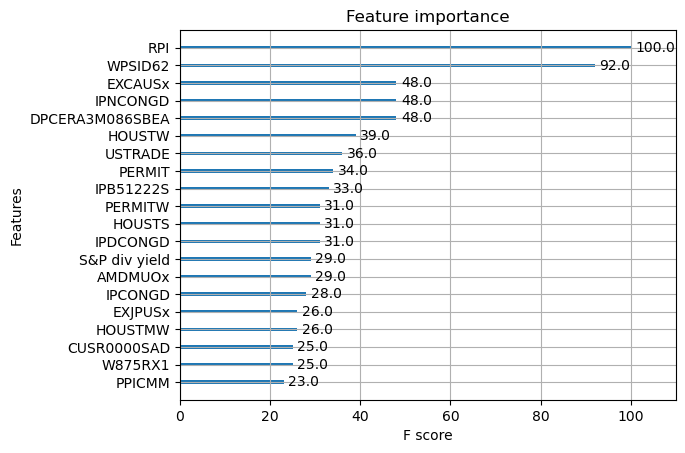

In [6]:
# Plotting feature importances for the best model
plt.figure(figsize=(10, 12))
plot_importance(best_xgb_model, max_num_features=20)
plt.show()

## Actual vs Predicted

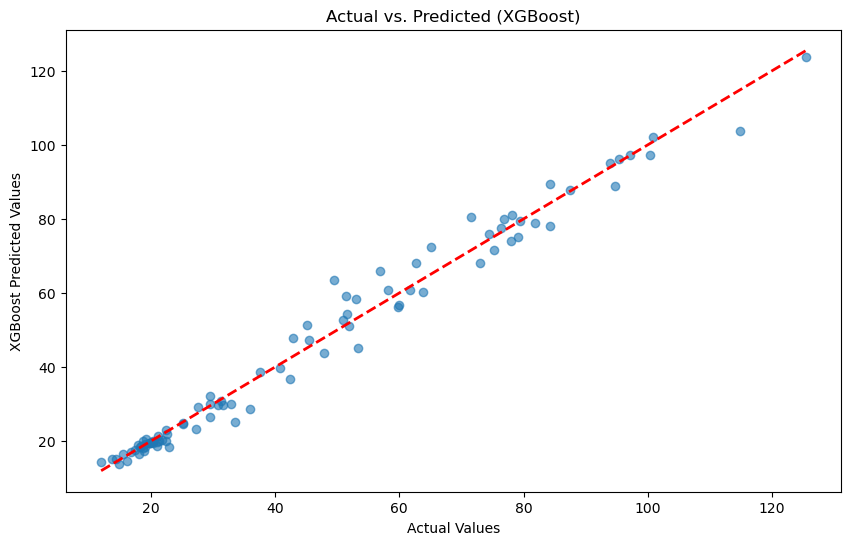

In [7]:
# Actual vs. Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('XGBoost Predicted Values')
plt.title('Actual vs. Predicted (XGBoost)')
plt.show()

### Learning Curve

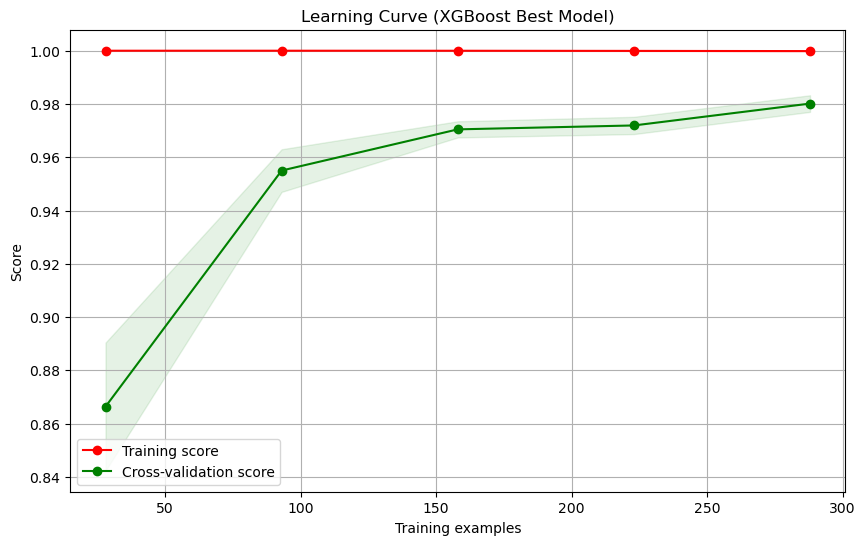

In [8]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Fill between lines to indicate standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the average training and test scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot the learning curve for the XGBoost model
plot_learning_curve(best_xgb_model, "Learning Curve (XGBoost Best Model)", X_train, y_train, cv=5)
plt.show()

- The Training score curve (in red) shows how the model's performance on the training data changes as more data is used.
- The Cross-validation score curve (in green) shows how the model's performance on a validation set changes as more training data is used.